In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker
import seaborn as sns
%load_ext autoreload
%autoreload 2

from settings import *
from url_helpers import analyze_url
from sklearn.metrics import cohen_kappa_score, mean_squared_error
from math import sqrt

In [2]:
figures = conf['aux_dir']+'figure-eight/'
trust_thr = .4

In [3]:
df = pd.read_csv(figures+'crispr-crowd.csv').rename(columns={'how_do_you_rate_the_scientific_quality_of_this_article': 'non-experts (w/o indicators)'})
df = df[df._trust > trust_thr][['article', 'non-experts (w/o indicators)']]
df.article = df.article.apply(lambda x: x.replace('https://', 'http://'))
print(df.shape)
df_crowd = df.groupby('article').mean()

(65, 2)


In [4]:
df = pd.read_csv(figures+'crispr-crowd-ind.csv').rename(columns={'how_do_you_rate_the_scientific_quality_of_this_article': 'non-experts (w/ indicators)'})
df = df[df._trust > trust_thr][['article', 'non-experts (w/ indicators)']]
df.article = df.article.apply(lambda x: x.replace('https://', 'http://'))
print(df.shape)
df_crowd_ind = df.groupby('article').mean()

(80, 2)


In [5]:
df1 = pd.read_csv(figures+'crispr-Dimitra.csv').rename(columns={'how_do_you_rate_the_scientific_quality_of_this_article': 'expert1'}).sort_values(by='article')
df2 = pd.read_csv(figures+'crispr-Jose.csv').rename(columns={'how_do_you_rate_the_scientific_quality_of_this_article': 'expert2'}).sort_values(by='article').drop('article', axis=1)
df_exp = pd.concat([df1,df2], axis=1)[['article', 'expert1', 'expert2']]
df_exp.article = df_exp.article.apply(lambda x: x.replace('https://', 'http://'))
df_exp['diff'] = abs(df_exp['expert1'] - df_exp['expert2'])
df_exp['experts'] = (df_exp['expert1'] + df_exp['expert2'])/2
df_exp = df_exp.set_index('article')
print(cohen_kappa_score(df_exp['expert1'], df_exp['expert2']))


0.04109589041095896


In [6]:
df_sci = pd.read_csv(cache_dir + 'scilens_crispr.tsv', sep='\t')
df_sci = df_sci.set_index('article').rename(columns={'scilens':'SciLens'})

In [7]:
df = df_crowd.join(df_exp).join(df_crowd_ind).join(df_sci).reset_index()

In [8]:
print(sqrt(mean_squared_error(df[df['diff']==0]['non-experts (w/o indicators)'], df[df['diff']==0]['experts'])))
print(sqrt(mean_squared_error(df[df['diff']==0]['non-experts (w/ indicators)'], df[df['diff']==0]['experts'])))
print(sqrt(mean_squared_error(df[df['diff']==0]['SciLens'], df[df['diff']==0]['experts'])))
print()
print(sqrt(mean_squared_error(df[df['diff']==1]['non-experts (w/o indicators)'], df[df['diff']==1]['experts'])))
print(sqrt(mean_squared_error(df[df['diff']==1]['non-experts (w/ indicators)'], df[df['diff']==1]['experts'])))
print(sqrt(mean_squared_error(df[df['diff']==1]['SciLens'], df[df['diff']==1]['experts'])))
print()
print(sqrt(mean_squared_error(df[df['diff']>1]['non-experts (w/o indicators)'], df[df['diff']>1]['experts'])))
print(sqrt(mean_squared_error(df[df['diff']>1]['non-experts (w/ indicators)'], df[df['diff']>1]['experts'])))
print(sqrt(mean_squared_error(df[df['diff']>1]['SciLens'], df[df['diff']>1]['experts'])))
print()
print(sqrt(mean_squared_error(df['non-experts (w/o indicators)'], df['experts'])))
print(sqrt(mean_squared_error(df['non-experts (w/ indicators)'], df['experts'])))
print(sqrt(mean_squared_error(df['SciLens'], df['experts'])))

1.4010578014353878
1.1710433777587372
1.0

0.8603939666093537
0.7624339679969377
0.6708203932499369

0.961046882889233
1.226048304286762
1.0307764064044151

1.069462481810372
1.0013463159389184
0.8587782018658834


In [9]:
df = df.sort_values(by=['experts', 'diff'])
l = df['article'].apply(lambda x: analyze_url(x)[0]).tolist()
l = [{'futurism.com':'Futurism', 
  'motherjones.com': 'Mother Jones',
  'natureworldnews.com': 'Nature World News',
  'dailyhealthpost.com': 'Daily Health Post',
  'biotech-now.org': 'Biotech Now',
  'fooddemocracynow.org': 'Food Democracy Now (blog)',
  'huffingtonpost.com': 'Huffington Post',
  'theverge.com': 'The Verge',
  'genomealberta.ca': 'Genome Alberta',
  'labiotech.eu': 'Labiotech',
  'medicaldaily.com': 'Medical Daily',
  'mashable.com': 'Mashable',
  'newatlas.com': 'New Atlas',
  'ibtimes.co.uk': 'IBTimes',
  'shontavia.com': 'Shontavia Johnson (blog)',
  'joshmitteldorf.scienceblog.com': 'Josh Mitteldorf (blog)',
  'thebody.com': 'The Body',
 'medium.com' : 'Twist Bioscience'}.get(o, o) for o in l]
df['article'] = [v + ' (' + str(l[:i].count(v) + 1) + ')' if l.count(v) > 1 else v for i, v in enumerate(l)]
#df['article'] = df.apply(lambda x: x['article']+'*' if x['diff']==0 else x['article']+'**' if x['diff']==1 else x['article']+'***', axis = 1)

In [10]:
df = df[['article', 'non-experts (w/o indicators)', 'non-experts (w/ indicators)', 'experts', 'SciLens']]
df = pd.melt(df, id_vars=['article'], var_name='Rated by', value_name='Quality').rename(columns={'article': 'Outlet'})
df['Quality'] = df['Quality'] + 2

In [11]:
df = df.sort_values(by=['Rated by', 'Quality'], ascending=[True,True])
df = pd.concat([df[(df['Rated by'] == 'experts')],df[~(df['Rated by'] == 'experts')]])

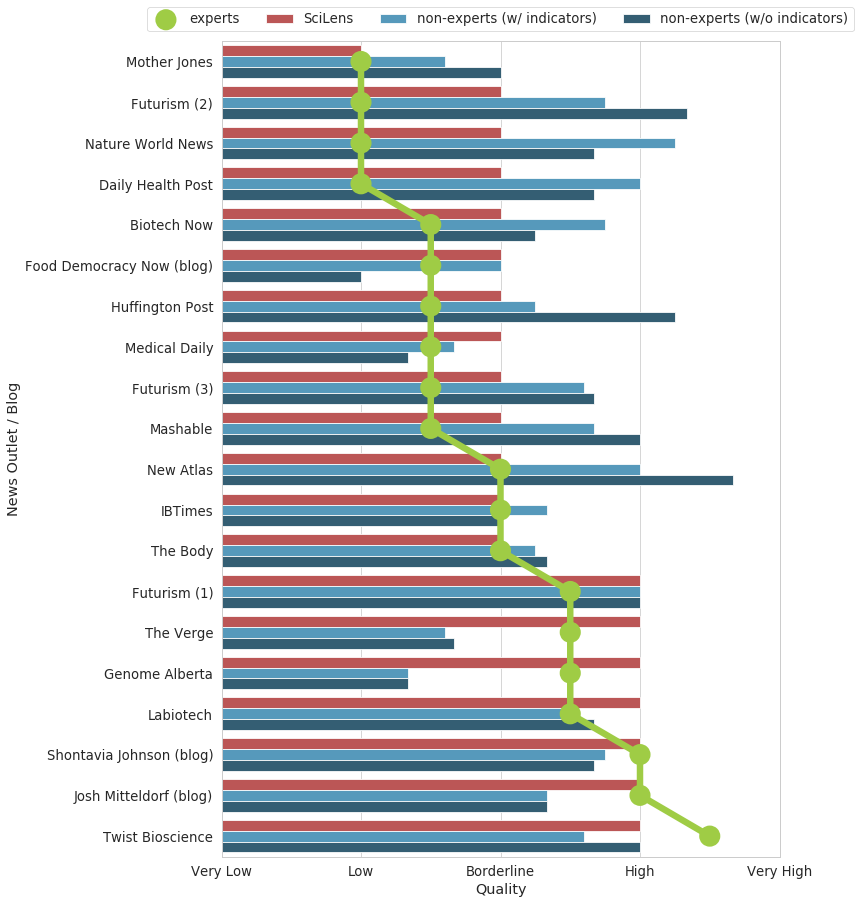

In [12]:
sns.set(context='paper', style='whitegrid', color_codes=True, font_scale=1.5)
fig, ax = plt.subplots(figsize=(10,15))
ax = sns.pointplot(hue='Rated by', x='Quality', y='Outlet', data=df[(df['Rated by'] == 'experts')], markers='o', palette=['#9FCC45'], scale=3, ax=ax)
plt.setp(ax.lines, zorder=100)
plt.setp(ax.collections, zorder=100)
ax = sns.barplot(hue='Rated by', x='Quality', y='Outlet', data=df[~(df['Rated by'] == 'experts')], palette=['#CC4545', '#459FCC', '#2A617D'], ax=ax)
ax.set_xticks(ticks=[0, 1, 2, 3, 4])
ax.set_xticklabels(['Very Low', 'Low', 'Borderline', 'High', 'Very High'])
#plt.xticks(rotation=90)
plt.legend(loc='upper center', ncol=4, bbox_to_anchor=(0.5, 1.05))
plt.ylabel('News Outlet / Blog')
fig.savefig(figures+'crispr.pdf', bbox_inches='tight')